# This is to test how Rvar varies with length of lightcurve

In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   'text.usetex': False,
   }
plt.rcParams.update(params)

In [9]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.utils as au
from astropy.io import fits

# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
print('McQuillian',np.shape(McQS))

# gaia data from https://gaia-kepler.fun/
with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep = False, inplace = True) 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]-np.shape(df)[0]))

McQuillian (34030, 11)
Cross-matched (32984, 145)
Missing 1046 stars


Code to read lightcurves from Ruth https://github.com/RuthAngus/amped/blob/master/code/kepler_data.py

In [29]:
from __future__ import print_function
import glob
import os
from tqdm import trange
def load_and_join(LC_DIR):
    """
    load and join quarters together.
    Takes a list of fits file names for a given star.
    Returns the concatenated arrays of time, flux and flux_err
    """
    fnames = sorted(glob.glob(os.path.join(LC_DIR, "*fits")))
    #print(fnames)
    hdulist = fits.open(fnames[0])
    t = hdulist[1].data
    time = t["TIME"]
    flux = t["PDCSAP_FLUX"]
    flux_err = t["PDCSAP_FLUX_ERR"]
    q = t["SAP_QUALITY"]
    m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(flux_err) * \
            (q == 0)
    x = time[m]
    med = np.median(flux[m])
    y = flux[m]/med - 1
    yerr = flux_err[m]/med
    for fname in fnames[1:]:
       hdulist = fits.open(fname)
       t = hdulist[1].data
       time = t["TIME"]
       flux = t["PDCSAP_FLUX"]
       flux_err = t["PDCSAP_FLUX_ERR"]
       q = t["SAP_QUALITY"]
       m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(flux_err) * \
               (q == 0)
       x = np.concatenate((x, time[m]))
       med = np.median(flux[m])
       y = np.concatenate((y, flux[m]/med - 1))
       yerr = np.concatenate((yerr, flux_err[m]/med))
    return x, y, yerr

def load_and_split(LC_DIR):
    """
    load individual quarters.
    Takes a list of fits file names for a given star.
    Returns a list of arrays of time, flux and flux_err
    """

    fnames = sorted(glob.glob(os.path.join(LC_DIR, "*fits")))
    time, flux, flux_err = [], [], []
    for i in range(len(fnames)):
        hdulist = fits.open(fnames[i])
        t = hdulist[1].data
        x, y, yerr = t["TIME"], t["PDCSAP_FLUX"], t["PDCSAP_FLUX_ERR"]
        m = np.isfinite(x) * np.isfinite(y) * np.isfinite(yerr) \
                        * (t["SAP_QUALITY"] == 0)

        time.append(x[m])
        med = np.median(y[m])
        flux.append(y[m]/med - 1)
        flux_err.append(yerr[m]/med)

    return time, flux, flux_err

Get lightcurves and saved in ~/.kplr/data/lightcurves/

In [157]:
import kplr # with pip install needed to change async into async_ for python 3.7...
import random
client = kplr.API()
# pick out # of stars
samplesize=300
KID_a = df.KID.values[random.sample(range(0,len(df.KID)), samplesize)] # list of KID
for KID in KID_a:
    star = client.star(str(KID))
    star.get_light_curves(fetch=True, short_cadence=False)

In [159]:
pathtolightcurves="/Users/lucy/Desktop/FirstYearML/lightcurves/"
dirc = os.listdir(pathtolightcurves)
samplesize=len(dirc)
# initialize all times/flux/flux_err
time=[[] for i in range(samplesize)]
flux=[[] for i in range(samplesize)]
flux_err=[[] for i in range(samplesize)]
KID_sort=np.zeros([samplesize,1])
for i in range(samplesize):
    KID_sort[i]=dirc[i]
    LC_DIR=pathtolightcurves+dirc[i]
    time[i], flux[i], flux_err[i]=load_and_join(LC_DIR)
KID_sort=[int(i) for i in KID_sort]

<ErrorbarContainer object of 3 artists>

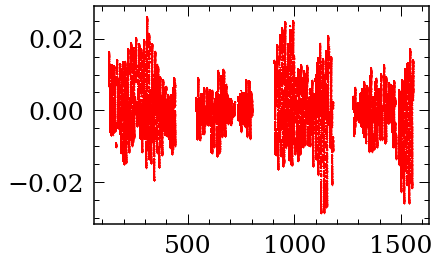

In [104]:
plt.figure()
plt.errorbar(time[0], flux[0], yerr=flux_err[0],fmt='r.',markersize=1)

In [160]:
# save file 
np.save('time',time)
np.save('flux',flux)
np.save('flux_err',flux_err)
#print(flux)

In [228]:
import timeit
print('Time for using i directly from flux:', timeit.timeit(lambda:[(np.percentile(i,95)-np.percentile(i,5)) for i in flux], number=5000))
print('Time for using i from indexing:', timeit.timeit(lambda:[(np.percentile(flux[i],95)-np.percentile(flux[i],5)) for i in range(len(flux))], number=5000))

Time for using i direction from flux: 1838.0821487610083
Time for using i from indexing: 1836.4939223110123


## covariance between Rper and Rvar

covariance matrix: 
 [[1.49619846e+08 1.70345357e+02]
 [1.70345357e+02 2.01826042e-04]]


'\nimport corner\n# plot corner plot\nsample=np.zeros([len(Rvar),2])\nsample[:,0]=Rper\nsample[:,1]=Rvar\nfigure=corner.corner(sample,labels=["Rper", "Rvar"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})\nplt.tight_layout()\n'

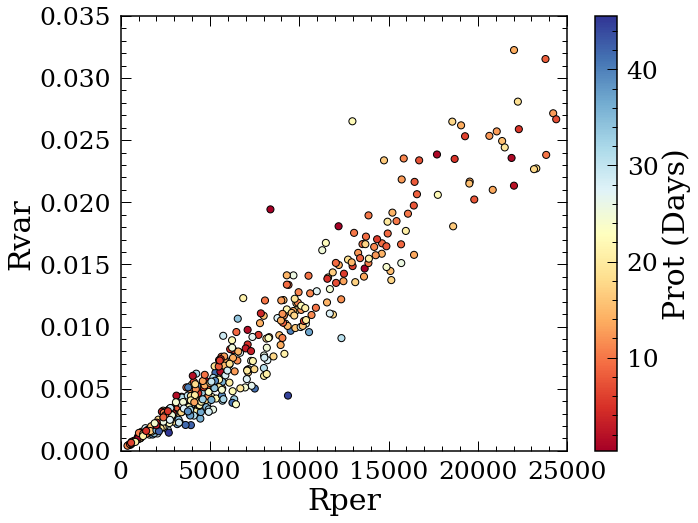

In [194]:
# get rotation periods and Rper of these stars (must be a easier way...)
Prot=[df.loc[df['KID']==KID_sort[i]].Prot.values for i in range(len(KID_sort))]
Rper=[df.loc[df['KID']==KID_sort[i]].Rper.values for i in range(len(KID_sort))]

# get Rvar from np.percentile(flux,95)-np.percentile(flux,5)
def getRvar(Flux):
    return abs(np.percentile(Flux,95)-np.percentile(Flux,5))
Rvar=[getRvar(i) for i in flux]
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(Rper,Rvar,c=Prot,s=50, cmap=cm,edgecolors='k')
cb=plt.colorbar()
cb.set_label('Prot (Days)')
plt.ylabel('Rvar')
plt.xlabel('Rper')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim([0,25000])
plt.ylim([0,0.035])

#print(np.shape(np.squeeze(Rper)),np.shape(Rvar))
print('covariance matrix: \n',np.cov(np.squeeze(Rper),Rvar))

'''
import corner
# plot corner plot
sample=np.zeros([len(Rvar),2])
sample[:,0]=Rper
sample[:,1]=Rvar
figure=corner.corner(sample,labels=["Rper", "Rvar"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})
plt.tight_layout()
'''

## Cut into 27 days

In [206]:
#print(len(time[0]/(max(time[0])-min(time[0])))) # points/day should have at lease this much points per day...
import random
import pandas as pd
def cut_lc(Time,Flux,Fluxerr,days): # cut out a random section of data
    #print(np.shape(Time))
    # days: how many days to cut the lightcurves into
    minpoints=len(Time)/(max(Time)-min(Time))*days*0.8 # min number of points to accept the cut
    rands=random.uniform(0, 1)
    startT=(max(Time)-min(Time)+days)*rands+min(Time)
    endT=startT+days
    # put these into dataframe
    data=np.array((Time,Flux,Fluxerr)).T
    columns=['Time','Flux','Flux_err']
    df=pd.DataFrame(data,columns=columns) 
    sel_df=df.loc[(df['Time']>startT) & (df['Time']<endT)] # get selected data
    # regenerate cut if too short
    while len(sel_df.Time)<minpoints:
        #print(len(sel_df.Time))
        rands=random.uniform(0, 1)
        startT=(min(Time)-max(Time)+days)*rands+min(Time)
        endT=startT+days
        sel_df=df.loc[(df['Time']>startT) & (df['Time']<endT)] # get selected data
    return sel_df

In [220]:
#sel_df=cut_lc(time[0],flux[0],flux_err[0],27.)
TestT=20 # how many times to cut the lightcurve to test
Rvar_27=np.zeros([len(time),TestT]) # Rvar for each lightcurve
oldperc=0.0
print('0.0 %')
for i in range(len(Prot)):
    if int(i/len(Prot)*100)!=int(oldperc):
        print(int(i/len(Prot)*100),'%')
        oldperc=int(i/len(Prot)*100)
    for j in range(TestT):
        sel_df=cut_lc(time[i],flux[i],flux_err[i],27.)
        #plt.figure()
        #plt.plot(sel_df['Flux'])
        #plt.show()
        Rvar_27[i,j]=getRvar(sel_df.Flux)
        #print(Rvar_27[i,j])

0.0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %


Mostly underestimated Rvar


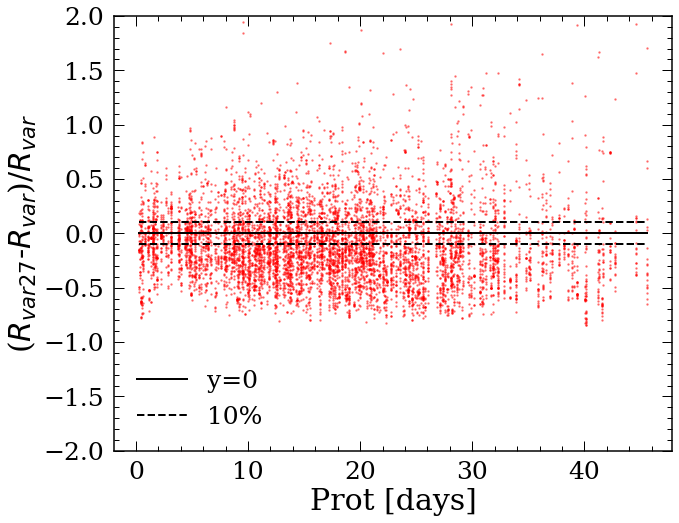

In [277]:
#print(Rvar_27)
# get mean and std for each Prot
meand=np.zeros(len(Prot))
stdd=np.zeros(len(Prot))
for i in range(len(Prot)):
    meand[i]=np.mean(Rvar_27[i,:]-Rvar[i])
    stdd[i]=np.std(Rvar_27[i,:]-Rvar[i])
plt.figure(figsize=(10,8))
for i in range(len(Prot)):
    plt.plot(np.ones([TestT,1])*Prot[i],(Rvar_27[i,:]-Rvar[i])/Rvar[i],'r.',markersize=3,alpha=0.4)
sortProt,sortMean,sortStd=zip(*sorted(zip(Prot,meand,stdd)))
#print(np.shape(sortProt),np.shape(sortMean),np.shape(sortStd))
plt.plot(sortProt,np.zeros(len(sortProt)),'k-',label='y=0')
plt.plot(sortProt,np.ones(len(sortProt))*0.1,'k--',label='10%')
plt.plot(sortProt,-np.ones(len(sortProt))*0.1,'k--')
plt.ylim([-2,2])
plt.legend()
plt.xlabel('Prot [days]')
plt.ylabel('($R_{var27}$-$R_{var}$)/$R_{var}$')
print('Mostly underestimated Rvar')

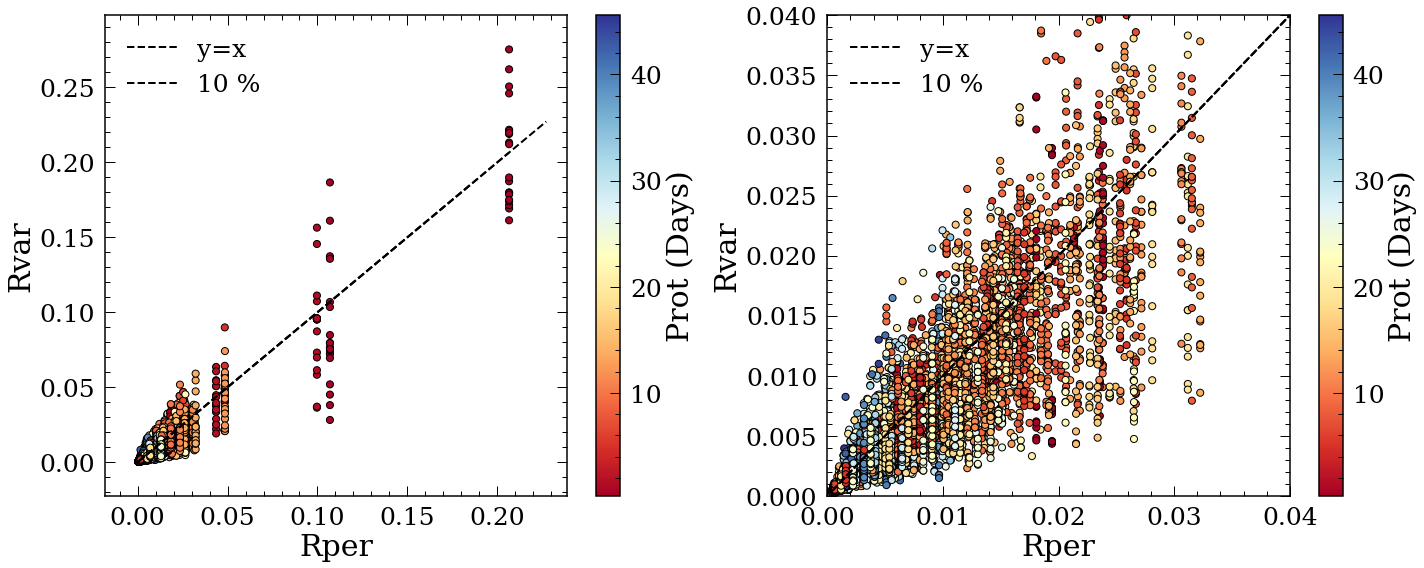

In [276]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
# get everything into 1d array
Rvar_27_ar=Rvar_27.ravel()
Rvar_ar=np.zeros(len(Rvar_27_ar))
Prot_ar=np.zeros(len(Rvar_27_ar))
for i in range(len(Prot)):
    Rvar_ar[i*20:i*20+20]=np.ones(TestT)*Rvar[i]
    Prot_ar[i*20:i*20+20]=np.ones(TestT)*Prot[i]
plt.scatter(Rvar_ar,Rvar_27_ar,c=Prot_ar,s=50, cmap=cm,edgecolors='k')
plt.plot(sorted(Rvar_ar),sorted(Rvar_ar),'k--',label='y=x')
plt.plot(sorted(Rvar_ar+0.1*Rvar_ar),sorted(Rvar_ar+0.1*Rvar_ar),'k--',label='10 %')
plt.plot(sorted(Rvar_ar-0.1*Rvar_ar),sorted(Rvar_ar-0.1*Rvar_ar),'k--')
plt.legend()
cb=plt.colorbar()
cb.set_label('Prot (Days)')
plt.ylabel('Rvar')
plt.xlabel('Rper')


# plotting same thing but zoomed in
plt.subplot(1,2,2)
# get everything into 1d array
Rvar_27_ar=Rvar_27.ravel()
Rvar_ar=np.zeros(len(Rvar_27_ar))
Prot_ar=np.zeros(len(Rvar_27_ar))
for i in range(len(Prot)):
    Rvar_ar[i*20:i*20+20]=np.ones(TestT)*Rvar[i]
    Prot_ar[i*20:i*20+20]=np.ones(TestT)*Prot[i]
plt.scatter(Rvar_ar,Rvar_27_ar,c=Prot_ar,s=50, cmap=cm,edgecolors='k')
plt.plot(sorted(Rvar_ar),sorted(Rvar_ar),'k--',label='y=x')
plt.plot(sorted(Rvar_ar+0.1*Rvar_ar),sorted(Rvar_ar+0.1*Rvar_ar),'k--',label='10 %')
plt.plot(sorted(Rvar_ar-0.1*Rvar_ar),sorted(Rvar_ar-0.1*Rvar_ar),'k--')
plt.legend()
cb=plt.colorbar()
cb.set_label('Prot (Days)')
plt.ylim([0,0.04])
plt.xlim([0,0.04])
plt.ylabel('Rvar')
plt.xlabel('Rper')

plt.tight_layout()


